## Importing the Dependencies

In [1]:
import pandas as pd , numpy as np 
import warnings                     
warnings.filterwarnings("ignore")
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor 
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
import re
from sklearn import metrics

## Data Collection

In [2]:
# Specify the file path
file_path = "DeepDDI-results_entire-drug-pairs.txt" 

# Read the data from the text file with tab separation
df = pd.read_csv(file_path, sep='\t', header=None,
                 names=["DDI type", "DeepDDI Output Sentence", "Output Neuron Activity", "S-score by Huang et al. (2013)", "Structurally Similar Drug"])

In [3]:
df.head()

,DDI type,DeepDDI Output Sentence,Output Neuron Activity,S-score by Huang et al. (2013),Structurally Similar Drug
0,DDI type,DeepDDI output sentence for the corresponding ...,Output neuron activity,S-score by Huang et al. (2013),Structurally similar drug member in drug pairs...
1,47,The metabolism of DB01197 can be decreased whe...,0.965315,NaN,DB06410 -> DB00169(P11473)
2,49,The risk or severity of adverse effects can be...,0.995729,0.43595587046,DB06412 -> DB00396(P06401|P03372|P08235);DB006...
3,47,The metabolism of DB01197 can be decreased whe...,0.9515,NaN,DB06413 -> DB00745(Q01959)
4,49,The risk or severity of adverse effects can be...,1.0,1.67579755691,DB06594 -> DB01065(P48039|P49286);DB00461(P353...


In [4]:
df = df.drop(0)

In [5]:
df.shape

(3632573, 5)

In [6]:
df['DDI type'].value_counts()

DDI type
49    1734748
47     430800
73     359081
70     209771
75     170933
       ...   
48          2
42          2
44          1
7           1
28          1
Name: count, Length: 164, dtype: int64

In [7]:
data = pd.read_excel("pnas.1803294115.sd01.xlsx")

In [8]:
data = data.drop(0)

In [9]:
data.columns = data.iloc[0]  # Set the first row as the header
data = data[1:]

In [10]:
data.head()

1,DDI type,General sentence structure
2,1,Drug a can cause a decrease in the absorption ...
3,2,Drug a can cause an increase in the absorption...
4,3,The absorption of Drug b can be decreased when...
5,4,The bioavailability of Drug b can be decreased...
6,5,The bioavailability of Drug b can be increased...


## Merging Data

In [11]:
# Merge the two DataFrames based on the "DDI type" column
merged_data = df.merge(data, on="DDI type", how="inner")

In [12]:
merged_data['DDI type'].value_counts()

DDI type
49    1734748
47     430800
73     359081
70     209771
75     170933
       ...   
26         26
43         23
44          7
1           7
42          2
Name: count, Length: 86, dtype: int64

In [13]:
merged_data.head()

,DDI type,DeepDDI Output Sentence,Output Neuron Activity,S-score by Huang et al. (2013),Structurally Similar Drug,General sentence structure
0,75,The serum concentration of DB01223 can be decr...,0.972133,NaN,DB08896 -> DB00398(P15056|P04049|P35916|P35968...,Drug a may increase the photosensitizing activ...
1,75,The serum concentration of DB01262 can be decr...,0.995778,NaN,DB08896 -> DB00398(P15056|P04049|P35916|P35968...,Drug a may increase the photosensitizing activ...
2,75,The serum concentration of DB01262 can be decr...,0.995778,NaN,DB01262 -> DB00441(None|P23921);DB00987(None|P...,Drug a may increase the photosensitizing activ...
3,75,The serum concentration of DB01265 can be decr...,0.664637,NaN,DB08896 -> DB00398(P15056|P04049|P35916|P35968...,Drug a may increase the photosensitizing activ...
4,75,The serum concentration of DB01265 can be decr...,0.664637,NaN,DB01265 -> DB00495(Q72547),Drug a may increase the photosensitizing activ...


In [14]:
merged_data.shape

(3501502, 6)

## Data Preprocessing

In [15]:
# Count the number of occurrences of each DDI type
ddi_type_counts = merged_data['DDI type'].value_counts()

# Calculate the number of samples to take for each DDI type
sample_size_per_ddi_type = 192000 // len(ddi_type_counts)

# Initialize an empty DataFrame for the sampled data
sampled_data = pd.DataFrame()

# Loop through each DDI type and sample the specified number of rows
for ddi_type, count in ddi_type_counts.items():
    sample_size = min(sample_size_per_ddi_type, count)
    sampled_data = pd.concat([sampled_data, merged_data[merged_data['DDI type'] == ddi_type].sample(n=sample_size, random_state=42)])

remaining_samples = 192000 - len(sampled_data)
if remaining_samples > 0:
    for ddi_type, count in ddi_type_counts.items():
        if remaining_samples == 0:
            break
        if count > sample_size_per_ddi_type:
            additional_samples = min(remaining_samples, count - sample_size_per_ddi_type)
            sampled_data = pd.concat([sampled_data, merged_data[merged_data['DDI type'] == ddi_type].sample(n=additional_samples, random_state=42)])
            remaining_samples -= additional_samples

# Reset the index of the sampled data
sampled_data.reset_index(drop=True, inplace=True)


In [16]:
sampled_data.shape

(192000, 6)

In [17]:
sampled_data.head()

,DDI type,DeepDDI Output Sentence,Output Neuron Activity,S-score by Huang et al. (2013),Structurally Similar Drug,General sentence structure
0,49,The risk or severity of adverse effects can be...,0.998408,NaN,DB08896 -> DB00398(P15056|P04049|P35916|P35968...,Drug a may increase the antipsychotic activiti...
1,49,The risk or severity of adverse effects can be...,0.998893,NaN,DB00418 -> DB00474(P14867);DB01353(P14867|P478...,Drug a may increase the antipsychotic activiti...
2,49,The risk or severity of adverse effects can be...,0.999307,NaN,DB00708 -> DB00813(P35372|P41143);DB00899(P353...,Drug a may increase the antipsychotic activiti...
3,49,The risk or severity of adverse effects can be...,0.99935,NaN,DB00635 -> DB00443(P04150);DB00959(P04150);DB0...,Drug a may increase the antipsychotic activiti...
4,49,The risk or severity of adverse effects can be...,0.996426,NaN,DB00681 -> DB00826(None);DB00646(None),Drug a may increase the antipsychotic activiti...


In [18]:
sampled_data['DDI type'].value_counts()

DDI type
49    68083
25     2232
85     2232
53     2232
10     2232
      ...  
26       26
43       23
44        7
1         7
42        2
Name: count, Length: 86, dtype: int64

In [19]:
sampled_data.isna().sum()

DDI type                               0
DeepDDI Output Sentence                0
Output Neuron Activity                 0
S-score by Huang et al. (2013)    153365
Structurally Similar Drug              0
General sentence structure             0
dtype: int64

In [20]:
sampled_data.drop('S-score by Huang et al. (2013)', axis = 1)

,DDI type,DeepDDI Output Sentence,Output Neuron Activity,Structurally Similar Drug,General sentence structure
0,49,The risk or severity of adverse effects can be...,0.998408,DB08896 -> DB00398(P15056|P04049|P35916|P35968...,Drug a may increase the antipsychotic activiti...
1,49,The risk or severity of adverse effects can be...,0.998893,DB00418 -> DB00474(P14867);DB01353(P14867|P478...,Drug a may increase the antipsychotic activiti...
2,49,The risk or severity of adverse effects can be...,0.999307,DB00708 -> DB00813(P35372|P41143);DB00899(P353...,Drug a may increase the antipsychotic activiti...
3,49,The risk or severity of adverse effects can be...,0.99935,DB00635 -> DB00443(P04150);DB00959(P04150);DB0...,Drug a may increase the antipsychotic activiti...
4,49,The risk or severity of adverse effects can be...,0.996426,DB00681 -> DB00826(None);DB00646(None),Drug a may increase the antipsychotic activiti...
...,...,...,...,...,...
191995,49,The risk or severity of adverse effects can be...,0.999707,DB00462 -> DB09300(P20309);DB01409(P20309);DB0...,Drug a may increase the antipsychotic activiti...
191996,49,The risk or severity of adverse effects can be...,0.967496,DB06787 -> DB00376(P11229);DB00810(P11229|Q158...,Drug a may increase the antipsychotic activiti...
191997,49,The risk or severity of adverse effects can be...,0.998757,DB09300 -> DB00747(P11229);DB00462(P11229|P081...,Drug a may increase the antipsychotic activiti...
191998,49,The risk or severity of adverse effects can be...,0.980797,DB01708 -> DB00741(P04150|P04083);DB00396(P064...,Drug a may increase the antipsychotic activiti...


In [21]:
sampled_data.shape

(192000, 6)

In [22]:
sampled_data['DDI type'].value_counts()

DDI type
49    68083
25     2232
85     2232
53     2232
10     2232
      ...  
26       26
43       23
44        7
1         7
42        2
Name: count, Length: 86, dtype: int64

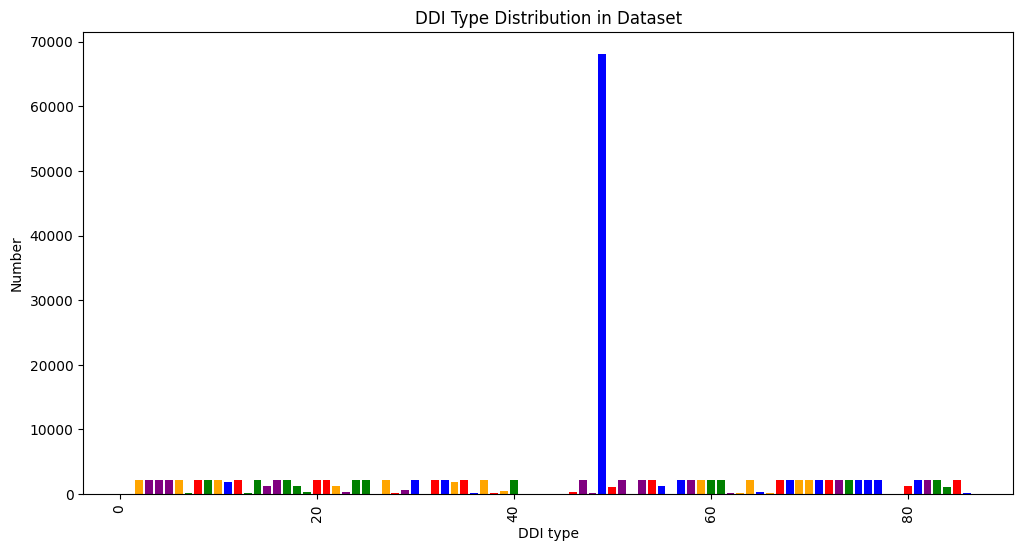

In [27]:
ddi_type_counts = sampled_data['DDI type'].value_counts()
ddi_types = ddi_type_counts.index
counts = ddi_type_counts.values
colors = ['blue', 'green', 'red', 'purple', 'orange']  
plt.figure(figsize=(12, 6)) 
plt.bar(ddi_types, counts, color=colors)
plt.xlabel('DDI type')
plt.ylabel('Number')
plt.title('DDI Type Distribution in Dataset')
plt.xticks(rotation=90)  
plt.show()

In [23]:
data = sampled_data['Structurally Similar Drug']

df = pd.DataFrame(data)

df['Drug1'] = df['Structurally Similar Drug'].str.extract(r'(DB\d+)')
df['Drug2'] = df['Structurally Similar Drug'].str.extract(r'-> (DB\d+)')

df['Info1'] = df['Structurally Similar Drug'].str.extract(r'\((.*?)\);')

In [24]:
df.head()

,Structurally Similar Drug,Drug1,Drug2,Info1
0,DB08896 -> DB00398(P15056|P04049|P35916|P35968...,DB08896,DB00398,NaN
1,DB00418 -> DB00474(P14867);DB01353(P14867|P478...,DB00418,DB00474,P14867
2,DB00708 -> DB00813(P35372|P41143);DB00899(P353...,DB00708,DB00813,P35372|P41143
3,DB00635 -> DB00443(P04150);DB00959(P04150);DB0...,DB00635,DB00443,P04150
4,DB00681 -> DB00826(None);DB00646(None),DB00681,DB00826,None


In [25]:
df[['Drug1','Drug2']]

,Drug1,Drug2
0,DB08896,DB00398
1,DB00418,DB00474
2,DB00708,DB00813
3,DB00635,DB00443
4,DB00681,DB00826
...,...,...
191995,DB00462,DB09300
191996,DB06787,DB00376
191997,DB09300,DB00747
191998,DB01708,DB00741


In [26]:
sampled_data[['Drug1','Drug2']] = df[['Drug1','Drug2']]

In [27]:
sampled_data.shape

(192000, 8)

In [28]:
sampled_data.tail()

,DDI type,DeepDDI Output Sentence,Output Neuron Activity,S-score by Huang et al. (2013),Structurally Similar Drug,General sentence structure,Drug1,Drug2
191995,49,The risk or severity of adverse effects can be...,0.999707,0.640234,DB00462 -> DB09300(P20309);DB01409(P20309);DB0...,Drug a may increase the antipsychotic activiti...,DB00462,DB09300
191996,49,The risk or severity of adverse effects can be...,0.967496,NaN,DB06787 -> DB00376(P11229);DB00810(P11229|Q158...,Drug a may increase the antipsychotic activiti...,DB06787,DB00376
191997,49,The risk or severity of adverse effects can be...,0.998757,1.414214,DB09300 -> DB00747(P11229);DB00462(P11229|P081...,Drug a may increase the antipsychotic activiti...,DB09300,DB00747
191998,49,The risk or severity of adverse effects can be...,0.980797,NaN,DB01708 -> DB00741(P04150|P04083);DB00396(P064...,Drug a may increase the antipsychotic activiti...,DB01708,DB00741
191999,49,The risk or severity of adverse effects can be...,0.998015,NaN,DB09396 -> DB00647(P35372|P41143|P41145),Drug a may increase the antipsychotic activiti...,DB09396,DB00647


In [29]:
def replace_a_b(text, drug1, drug2):
    if isinstance(text, str):
        text = text.replace(' a ', f' {drug1} ')
        text = text.replace(' b ', f' {drug2} ')
    return text

sampled_data['General sentence structure'] = sampled_data.apply(lambda row: replace_a_b(row['General sentence structure'], row['Drug1'], row['Drug2']), axis=1)


In [30]:
drug_pairs = sampled_data.drop(['Structurally Similar Drug','S-score by Huang et al. (2013)'], axis=1)

In [31]:
drug_pairs.isna().sum()

DDI type                      0
DeepDDI Output Sentence       0
Output Neuron Activity        0
General sentence structure    0
Drug1                         0
Drug2                         0
dtype: int64

In [32]:
drug_pairs.shape

(192000, 6)

In [33]:
drug_pairs.head()

,DDI type,DeepDDI Output Sentence,Output Neuron Activity,General sentence structure,Drug1,Drug2
0,49,The risk or severity of adverse effects can be...,0.998408,Drug DB08896 may increase the antipsychotic ac...,DB08896,DB00398
1,49,The risk or severity of adverse effects can be...,0.998893,Drug DB00418 may increase the antipsychotic ac...,DB00418,DB00474
2,49,The risk or severity of adverse effects can be...,0.999307,Drug DB00708 may increase the antipsychotic ac...,DB00708,DB00813
3,49,The risk or severity of adverse effects can be...,0.99935,Drug DB00635 may increase the antipsychotic ac...,DB00635,DB00443
4,49,The risk or severity of adverse effects can be...,0.996426,Drug DB00681 may increase the antipsychotic ac...,DB00681,DB00826


In [34]:
drug_pairs['DDI type'].value_counts()

DDI type
49    68083
25     2232
85     2232
53     2232
10     2232
      ...  
26       26
43       23
44        7
1         7
42        2
Name: count, Length: 86, dtype: int64

## Label Encoder

In [35]:
# Create a LabelEncoder
label_encoder = LabelEncoder()

# Encode the 'DeepDDI Output Sentence' and 'Structurally Similar Drug' columns
drug_pairs['General sentence structure_label'] = label_encoder.fit_transform(drug_pairs['General sentence structure'])
drug_pairs['DeepDDI Output Sentence_label'] = label_encoder.fit_transform(drug_pairs['DeepDDI Output Sentence'])

In [36]:
drug_pairs.shape

(192000, 8)

In [37]:
drug_pairs.head()

,DDI type,DeepDDI Output Sentence,Output Neuron Activity,General sentence structure,Drug1,Drug2,General sentence structure_label,DeepDDI Output Sentence_label
0,49,The risk or severity of adverse effects can be...,0.998408,Drug DB08896 may increase the antipsychotic ac...,DB08896,DB00398,8394,155039
1,49,The risk or severity of adverse effects can be...,0.998893,Drug DB00418 may increase the antipsychotic ac...,DB00418,DB00474,1476,138669
2,49,The risk or severity of adverse effects can be...,0.999307,Drug DB00708 may increase the antipsychotic ac...,DB00708,DB00813,3039,122698
3,49,The risk or severity of adverse effects can be...,0.99935,Drug DB00635 may increase the antipsychotic ac...,DB00635,DB00443,2617,139846
4,49,The risk or severity of adverse effects can be...,0.996426,Drug DB00681 may increase the antipsychotic ac...,DB00681,DB00826,2876,121773


In [38]:
drug_pairs['DDI type'].value_counts()

DDI type
49    68083
25     2232
85     2232
53     2232
10     2232
      ...  
26       26
43       23
44        7
1         7
42        2
Name: count, Length: 86, dtype: int64

## Spliting the Data 

In [39]:
x = drug_pairs[['General sentence structure_label','DeepDDI Output Sentence_label','Output Neuron Activity']]
y = drug_pairs['DDI type']

## Train Test Split

In [40]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=2)

In [41]:
print(x.shape,x_train.shape,x_test.shape)

(192000, 3) (153600, 3) (38400, 3)


In [42]:
print(x_train.dtypes)

General sentence structure_label     int32
DeepDDI Output Sentence_label        int32
Output Neuron Activity              object
dtype: object


In [43]:
print(y_train.dtypes)

object


## Random Forest 

In [44]:
RFC = RandomForestRegressor()

In [45]:
RFC.fit(x_train, y_train)

RandomForestRegressor()

In [46]:
x_train_prediction = RFC.predict(x_train)

In [47]:
x_test_prediction = RFC.predict(x_test)

## Model Evaluation on Random Forest

In [48]:
# Accuracy score for prediction on training data
# R Squared Error
score_1 =metrics.r2_score(y_train,x_train_prediction)
print('R Squared Error For Training Data : ',score_1)

R Squared Error For Training Data :  0.99313530817646


In [49]:
# Accuracy score for prediction on test data
# R Squared Error
score_2 =metrics.r2_score(y_test,x_test_prediction)
print('R Squared Error For test Data : ',score_2)

R Squared Error For test Data :  0.9508105344909968


## Cross Validation on Random Forest

In [51]:
CV_scores_RFC = cross_val_score(RandomForestRegressor(), x, y, cv=5, scoring='r2')

In [52]:
print(CV_scores_RFC)

[ 0.36410017  0.25257706  0.23984322 -0.14368246  0.        ]


In [58]:
CV_scores_RFC_2 = (1-CV_scores_RFC)*100
print(CV_scores_RFC_2)

[ 63.58998287  74.74229391  76.0156778  114.36824578 100.        ]


In [56]:
CV_scores_RFC_mean = sum(CV_scores_RFC)/len(CV_scores_RFC)
CV_scores_RFC_mean = (1-CV_scores_RFC_mean)*100
print(CV_scores_RFC_mean)

85.74324007208298


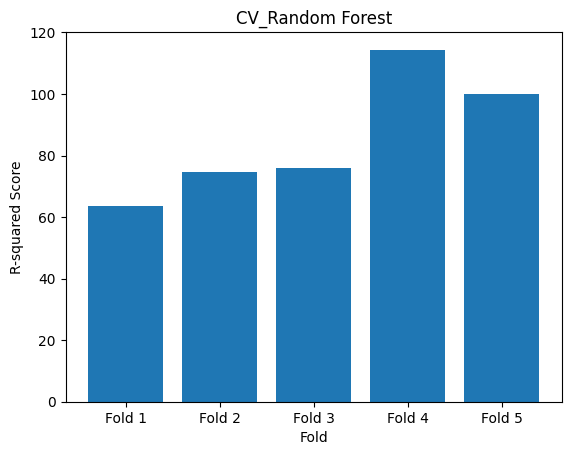

In [61]:
# Create a bar plot
plt.bar(range(len(CV_scores_RFC_2)), CV_scores_RFC_2, tick_label=['Fold 1', 'Fold 2', 'Fold 3', 'Fold 4', 'Fold 5'])
plt.xlabel('Fold')
plt.ylabel('R-squared Score')
plt.title('CV_Random Forest')
plt.show()

## Building the Neural Network 

In [62]:
x_train['Output Neuron Activity'] = x_train['Output Neuron Activity'].astype(float)

In [63]:
y_train = y_train.astype(int)

In [64]:
print(y_train.dtypes)

int32


In [65]:
print(x_train.dtypes)

General sentence structure_label      int32
DeepDDI Output Sentence_label         int32
Output Neuron Activity              float64
dtype: object


In [70]:
num_classes = 86  # The number of unique classes

# Convert y_train to one-hot encoded format
y_train_one_hot = tf.one_hot(y_train, depth=num_classes)
y_test_one_hot = tf.one_hot(y_test, depth=num_classes)

In [66]:
# importing the tensorflow & keras
import tensorflow as tf
tf.random.set_seed(3)
from tensorflow import keras

In [71]:
# Define the model and compile it outside the decorated function
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(3,)),
    keras.layers.Dense(20, activation='relu'),
    keras.layers.Dense(86, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['mae'])

# Train the model
history = model.fit(x_train, y_train_one_hot, validation_split=0.1, epochs=10)

Epoch 1/10
4320/4320 [==============================] - 6s 1ms/step - loss: 518.5591 - mae: 0.0172 - val_loss: 174.3341 - val_mae: 0.0150
Epoch 2/10
4320/4320 [==============================] - 6s 1ms/step - loss: 146.6969 - mae: 0.0171 - val_loss: 118.7549 - val_mae: 0.0148
Epoch 3/10
4320/4320 [==============================] - 7s 2ms/step - loss: 81.2924 - mae: 0.0171 - val_loss: 47.8045 - val_mae: 0.0165
Epoch 4/10
4320/4320 [==============================] - 5s 1ms/step - loss: 32.4586 - mae: 0.0169 - val_loss: 16.2041 - val_mae: 0.0147
Epoch 5/10
4320/4320 [==============================] - 7s 2ms/step - loss: 13.0089 - mae: 0.0172 - val_loss: 4.6409 - val_mae: 0.0174
Epoch 6/10
4320/4320 [==============================] - 6s 1ms/step - loss: 3.6840 - mae: 0.0176 - val_loss: 2.9913 - val_mae: 0.0174
Epoch 7/10
4320/4320 [==============================] - 6s 1ms/step - loss: 2.9052 - mae: 0.0173 - val_loss: 2.8859 - val_mae: 0.0167
Epoch 8/10
4320/4320 [===========================

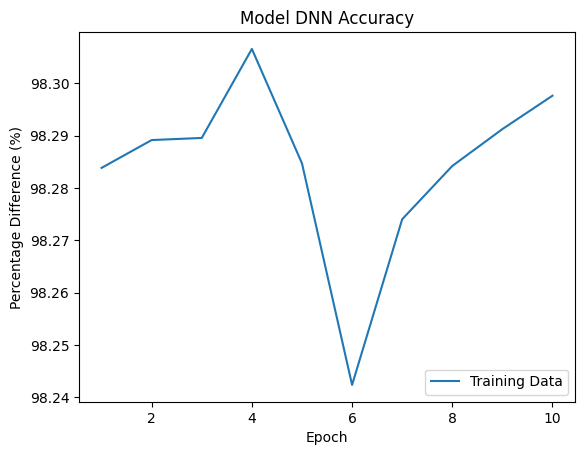

In [79]:
mae_values = history.history['mae']
# Calculate the percentage difference
percentage_difference = [100 - (mae * 100) for mae in mae_values]
epochs = range(1, len(mae_values) + 1)
# Create a line plot
plt.plot(epochs, percentage_difference)
plt.title('Model DNN Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Percentage Difference (%)')
plt.legend(['Training Data'], loc='lower right')
plt.show()

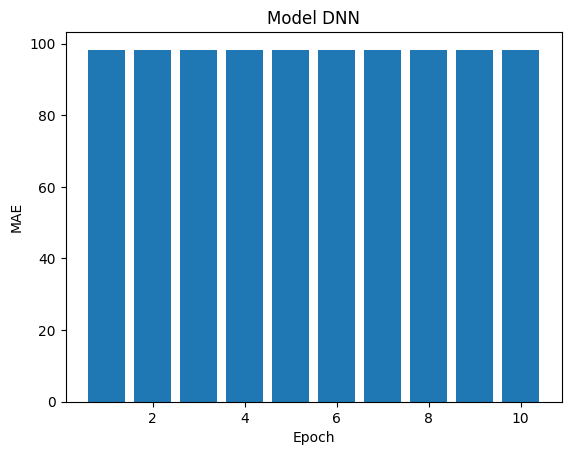

In [80]:
# Create a bar plot for DNN
mae_values = history.history['mae']
percentage_difference = [100 - (mae * 100) for mae in mae_values]
epochs = range(1, len(mae_values) + 1)
plt.bar(epochs, percentage_difference)
plt.title('Model DNN')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.show()

In [63]:
# Testing the neural network
model.evaluate(x_test, y_test_one_hot)

1200/1200 [==============================] - 1s 1ms/step - loss: 3.3226 - mae: 0.0202


[3.3225622177124023, 0.020155899226665497]

## Building Recurrent Neural Networks 

In [67]:
x_train = np.array( x_train)

In [68]:
y_train = np.array(y_train)

In [69]:
x_test = np.array(x_test, dtype=np.float32)
y_test = np.array(y_test, dtype=np.float32)

In [75]:
model_rnn = keras.Sequential([
    keras.layers.LSTM(64, return_sequences=True, input_shape=(x_train.shape[1], 1)),
    keras.layers.LSTM(64),
    keras.layers.Dense(1)  
])

model_rnn.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

In [76]:
# Training the RNN
model_rnn.fit(x_train, y_train_one_hot, epochs=5, batch_size=1)

Epoch 1/5
153600/153600 [==============================] - 573s 4ms/step - loss: 0.0115 - mae: 0.0229
Epoch 2/5
153600/153600 [==============================] - 603s 4ms/step - loss: 0.0115 - mae: 0.0229
Epoch 3/5
153600/153600 [==============================] - 603s 4ms/step - loss: 0.0115 - mae: 0.0229
Epoch 4/5
153600/153600 [==============================] - 606s 4ms/step - loss: 0.0115 - mae: 0.0229
Epoch 5/5
153600/153600 [==============================] - 612s 4ms/step - loss: 0.0115 - mae: 0.0229


In [55]:
# Testing the RNN
model_rnn.evaluate(x_test, y_test_one_hot)

1200/1200 [==============================] - 7s 4ms/step - loss: 0.0436 - mae: 0.1791


[0.043573047965765, 0.17912697792053223]

## Comparing Models

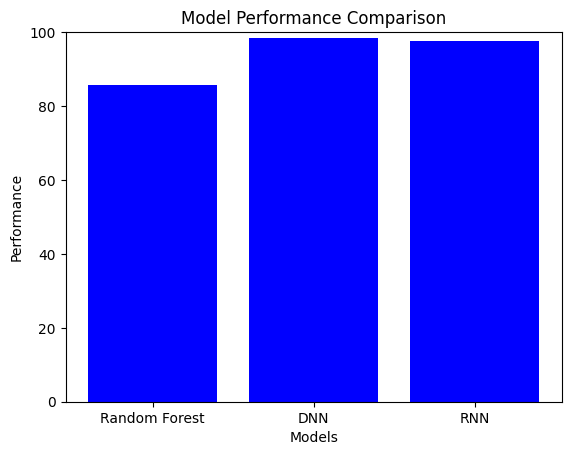

In [86]:
models =['Random Forest', 'DNN', 'RNN']
models_performance = [85.74,98.34,97.71]

# Create a bar plot
plt.bar(models, models_performance, color='blue')
plt.xlabel('Models')
plt.ylabel('Performance')
plt.title('Model Performance Comparison')
plt.ylim(0, 100)  
plt.show()